# Collaborative Filtering with Neural Networks¶
In this notebook we will write a matrix factorization model in pytorch to solve a recommendation problem. Then we will write a more general neural model for the same problem.

Collaborative filtering: systems recommend items based on similarity measures between users and/or items. The items recommended to a user are those preferred by similar users.

The MovieLens dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. https://grouplens.org/datasets/movielens/. To get the data:

wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
PATH = Path("./data/ml-latest-small/")
list(PATH.iterdir())

[PosixPath('data/ml-latest-small/README.txt'),
 PosixPath('data/ml-latest-small/histories'),
 PosixPath('data/ml-latest-small/models'),
 PosixPath('data/ml-latest-small/tags.csv'),
 PosixPath('data/ml-latest-small/ratings.csv'),
 PosixPath('data/ml-latest-small/links.csv'),
 PosixPath('data/ml-latest-small/movies.csv')]

In [3]:
# reading a csv into pandas
data = pd.read_csv(PATH/"ratings.csv")

In [4]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Encoding data
We enconde the data to have contiguous ids for users and movies. You can think about this as a categorical encoding of our two categorical variables userId and movieId.

In [5]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [6]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [7]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [8]:
# to check my implementation
df_t = pd.read_csv("./data/tiny_training2.csv")
df_v = pd.read_csv("./data/tiny_val2.csv")
df_t_e = encode_data(df_t)
df_v_e = encode_data(df_v, df_t)
df_v_e
df_t_e

,userId,movieId,rating
0,0,0,4
1,0,1,5
2,1,1,5
3,1,2,3
4,2,0,4
5,2,1,4
6,3,0,5
7,3,3,2
8,4,0,1
9,4,3,4


In [9]:
df_train = encode_data(train)
df_val = encode_data(val, train)

In [10]:
print(df_train.head())

   userId  movieId  rating  timestamp
0       0        0     4.0  964982703
1       0        1     4.0  964981247
2       0        2     4.0  964982224
3       0        3     5.0  964983815
6       0        4     5.0  964980868


In [11]:
users = data.userId.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
movies = data.movieId.unique()
movie_map = {i:val for i,val in enumerate(movies)}
inverse_movie_map = {val:i for i,val in enumerate(movies)}

print ("We have %d users"%users.shape[0])
print ("We have %d movies"%movies.shape[0])

We have 610 users
We have 9724 movies


In [12]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape
from keras.layers.merge import Multiply
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras import optimizers

Using TensorFlow backend.


In [13]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

In [14]:
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

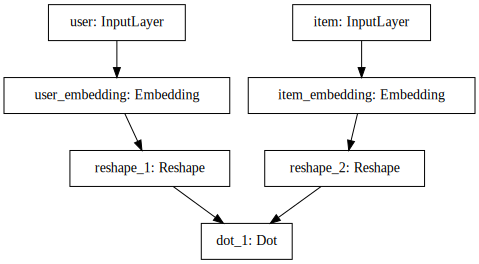

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [17]:
import time
from keras.callbacks import ModelCheckpoint
mainpath = "./data/ml-latest-small"
save_path = mainpath + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [18]:
history = model.fit([df_train["userId"], df_train["movieId"]]
                    , df_train["rating"]
                    , batch_size=64, epochs=10
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 72405 samples, validate on 8045 samples
Epoch 1/10
72405/72405 [==============================] - 3s 43us/step - loss: 11.5400 - val_loss: 11.5796
Epoch 2/10
72405/72405 [==============================] - 2s 31us/step - loss: 3.3168 - val_loss: 11.4518
Epoch 3/10
72405/72405 [==============================] - 2s 31us/step - loss: 1.6174 - val_loss: 11.4373
Epoch 4/10
72405/72405 [==============================] - 2s 29us/step - loss: 1.1307 - val_loss: 11.4307
Epoch 5/10
72405/72405 [==============================] - 2s 30us/step - loss: 0.9071 - val_loss: 11.4275
Epoch 6/10
72405/72405 [==============================] - 2s 30us/step - loss: 0.7809 - val_loss: 11.4250
Epoch 7/10
72405/72405 [==============================] - 2s 29us/step - loss: 0.7001 - val_loss: 11.4225
Epoch 8/10
72405/72405 [==============================] - 2s 29us/step - loss: 0.6428 - val_loss: 11.4221
Epoch 9/10
72405/72405 [==============================

In [19]:
import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [20]:
# the embeddings are the first layer weights
from keras.models import load_model
load_path = save_path
model = load_model(load_path+'/matrix_facto_50_2019_03_20_12_31.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print("weights shapes",[w.shape for w in weights])

weights shapes [(610, 30), (9724, 30)]


In [21]:
# reading a csv into pandas
movies = pd.read_csv(PATH/"movies.csv")

In [22]:
namesdic = {row[1]['movieId']:row[1]['title']  for row in movies.iterrows()}

In [23]:
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [24]:
print(namesdic[4])

Waiting to Exhale (1995)


In [49]:
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)


def cosine_similarities(x,embeddings):
    dot_pdt = np.dot(embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(embeddings,axis = 1)
    return dot_pdt / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x,embeddings):  
    return np.linalg.norm(embeddings - x,axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, embeddings, top_n=10, euclidian= False):
    if euclidian:
        # eucliedian distance between idx and the rest
        distance = euclidean_distances(embeddings[idx], embeddings)
        order = (distance).argsort()
        order = [x for x in order if x != idx]
        order = order[:top_n]
        order = [x for x in order if x in namesdic]
        return list(zip([namesdic[x] for x in order], distance[order]))
    else: 
        # cosine similarity between idx and the rest
        distance = cosine_similarities(embeddings[idx], embeddings)
        order = (-distance).argsort()
        order = [x for x in order if x != idx]        
        order = order[:top_n]
        order = [x for x in order if x in namesdic] 
        return list(zip([namesdic[x] for x in order], distance[order]))

In [50]:
from IPython.core import display as ICD
dataframes = []
for i,row in enumerate(movies.iterrows()):
    if i > 10:
        break
    row = row[1]
    #print(row)
    #print(row.title)
    #print('-'*10)
    similars = pd.DataFrame(most_similar(row["movieId"],
                                         item_embeddings,
                                         top_n=10,
                                         euclidian= False))
    similars.columns = [row["title"], ' Score' ]
    dataframes.append(similars)
    if i % 2 == 1 :
        final = pd.concat(dataframes,axis=1)
        ICD.display(final)
        dataframes=[]

,Toy Story (1995),Score,Jumanji (1995),Score
0,"Beverly Hillbillies, The (1993)",0.947893,Philadelphia (1993),0.947208
1,Englishman Who Went Up a Hill But Came Down a ...,0.929413,"Pagemaster, The (1994)",0.945138
2,Dazed and Confused (1993),0.929125,"Man Without a Face, The (1993)",0.942047
3,"Pagemaster, The (1994)",0.921411,Batman (1989),0.938034
4,Barcelona (1994),0.920281,"Great Day in Harlem, A (1994)",0.933030
5,Surviving the Game (1994),0.918430,Godzilla (Gojira) (1954),0.932923
6,"Man Without a Face, The (1993)",0.917426,Judgment Night (1993),0.931660
7,RoboCop 3 (1993),0.914616,"Cat from Outer Space, The (1978)",0.930336
8,NaN,NaN,Homeward Bound II: Lost in San Francisco (1996),0.929297


,Grumpier Old Men (1995),Score,Waiting to Exhale (1995),Score
0,Hideaway (1995),0.918702,"Adventures of Huck Finn, The (1993)",0.944983
1,Mallrats (1995),0.902439,Missing (1982),0.941012
2,Bound (1996),0.895319,Party Girl (1995),0.937790
3,Persuasion (1995),0.889788,Rambo III (1988),0.936101
4,Little Women (1994),0.887774,"Last Unicorn, The (1982)",0.934574
5,S.F.W. (1994),0.878422,Tremors II: Aftershocks (1996),0.934420
6,Home Alone (1990),0.876224,Tuesdays with Morrie (1999),0.932457
7,Foreign Correspondent (1940),0.875130,Rosencrantz and Guildenstern Are Dead (1990),0.930590
8,Menace II Society (1993),0.872856,NaN,NaN


,Father of the Bride Part II (1995),Score,Heat (1995),Score
0,Heat (1995),0.931786,Father of the Bride Part II (1995),0.931786
1,Englishman Who Went Up a Hill But Came Down a ...,0.926270,Home Alone (1990),0.921463
2,"Pagemaster, The (1994)",0.923372,"Pagemaster, The (1994)",0.920907
3,Home Alone (1990),0.914989,In the Line of Fire (1993),0.908509
4,Ghost (1990),0.912645,Four Rooms (1995),0.907338
5,Something Wild (1986),0.911489,Tin Cup (1996),0.907106
6,Menace II Society (1993),0.908734,RoboCop 3 (1993),0.901976
7,NaN,NaN,Something Wild (1986),0.898134


,Sabrina (1995),Score,Tom and Huck (1995),Score
0,Black Christmas (1974),0.948629,"Others, The (2001)",0.925664
1,Extreme Ops (2002),0.948016,Withnail & I (1987),0.919741
2,When a Stranger Calls (1979),0.946926,"Adventures of Elmo in Grouchland, The (1999)",0.919621
3,Atlantis: The Lost Empire (2001),0.945897,Charlie's Angels: Full Throttle (2003),0.918244
4,Chopper Chicks in Zombietown (1989),0.944400,"American Tail: Fievel Goes West, An (1991)",0.917249
5,Hudson Hawk (1991),0.944237,Adanggaman (2000),0.916306
6,Tully (2000),0.943995,NaN,NaN
7,"Wedding Banquet, The (Xi yan) (1993)",0.942815,NaN,NaN


,Sudden Death (1995),Score,GoldenEye (1995),Score
0,Surviving the Game (1994),0.907636,Street Fighter (1994),0.940057
1,Batman (1989),0.903855,"Secret of NIMH, The (1982)",0.935655
2,Terminator 2: Judgment Day (1991),0.903672,Godzilla (Gojira) (1954),0.932310
3,"Beverly Hillbillies, The (1993)",0.901661,"Dead Zone, The (1983)",0.928938
4,Stalker (1979),0.900832,Made in America (1993),0.928799
5,Little Women (1994),0.896570,Go Fish (1994),0.927292
6,"Graduate, The (1967)",0.895736,Georgia (1995),0.926655
7,Kalifornia (1993),0.890601,"Brothers McMullen, The (1995)",0.925885
8,Casino (1995),0.889457,About Last Night... (1986),0.924308
9,NaN,NaN,"Pagemaster, The (1994)",0.924096
